In [23]:
!gdown "1-2YFjkO38iyZgzcxu1ylhRwZUtr51TxO" --output "house-prices-tp.csv"

Downloading...
From: https://drive.google.com/uc?id=1-2YFjkO38iyZgzcxu1ylhRwZUtr51TxO
To: c:\Users\Usuario\Desktop\TUIA\AA1-TUIA-Avecilla-Calcia\AA1-TUIA-Avecilla-Calcia\house-prices-tp.csv

  0%|          | 0.00/46.9k [00:00<?, ?B/s]
100%|██████████| 46.9k/46.9k [00:00<00:00, 23.4MB/s]


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [105]:
df_precios_casas = pd.read_csv("house-prices-tp.csv")
df_original = df_precios_casas.copy()


In [106]:
df_precios_casas.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,533.000000,534.000000,541.000000,533.000000,532.000000,535.000000,532.000000,541.000000,528.000000,538.000000,528.000000,534.000000,534.000000,535.000000
mean,5.845517,13.197175,11.218725,0.090056,0.560050,6.291839,67.632303,3.944102,9.699379,409.575089,18.429904,347.806040,13.028092,22.746809
std,13.828631,24.902981,6.942021,0.286531,0.119472,0.782403,28.461925,2.255689,8.684495,167.689379,2.194759,99.636208,7.579972,9.491452
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.084470,0.000000,5.130000,0.000000,0.453000,5.875500,42.275000,2.112100,4.000000,279.000000,17.000000,369.530000,7.150000,16.750000
50%,0.315330,0.000000,9.690000,0.000000,0.538000,6.208000,76.500000,3.340107,5.000000,335.000000,19.000000,390.815000,11.465000,21.200000
75%,4.871410,20.000000,18.100000,0.000000,0.643986,6.638500,93.825000,5.400700,23.632660,666.000000,20.200000,395.890000,17.205000,26.300000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [94]:
df_precios_casas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 556 entries, 0 to 555
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     533 non-null    float64
 1   ZN       534 non-null    float64
 2   INDUS    541 non-null    float64
 3   CHAS     533 non-null    float64
 4   NOX      532 non-null    float64
 5   RM       535 non-null    float64
 6   AGE      532 non-null    float64
 7   DIS      541 non-null    float64
 8   RAD      528 non-null    float64
 9   TAX      538 non-null    float64
 10  PTRATIO  528 non-null    float64
 11  B        534 non-null    float64
 12  LSTAT    534 non-null    float64
 13  MEDV     535 non-null    float64
dtypes: float64(14)
memory usage: 60.9 KB


### Verificamos valores nulos

In [95]:
conteo_nan = df_precios_casas.isnull().sum()
conteo_nan

CRIM       23
ZN         22
INDUS      15
CHAS       23
NOX        24
RM         21
AGE        24
DIS        15
RAD        28
TAX        18
PTRATIO    28
B          22
LSTAT      22
MEDV       21
dtype: int64

In [107]:
filas_nan = []

for index, row in df_precios_casas.iterrows():
    # Verificamos si la fila tiene más de 11 NaN o si el valor de MEDV es NaN
    if row.isnull().sum() > 11 or pd.isnull(row['MEDV']):
        filas_nan.append(index)

df_precios_casas.drop(index=filas_nan, inplace=True)

print(f"Filas eliminadas: {len(filas_nan)}")


Filas eliminadas: 21


In [97]:
conteo_nan = df_precios_casas.isnull().sum()
conteo_nan

CRIM       11
ZN         11
INDUS       4
CHAS        9
NOX         9
RM          7
AGE        11
DIS         5
RAD        12
TAX         9
PTRATIO     9
B           9
LSTAT       9
MEDV        0
dtype: int64

### Imputaremos la columna binaria con la moda

In [108]:
df_precios_casas['CHAS'] = df_precios_casas['CHAS'].fillna(df_precios_casas['CHAS'].mode()[0])

### Y el resto de columnas seran inputadas con KNN

In [109]:
# Crear el imputador KNN
imputer = KNNImputer(n_neighbors=5)

# Aplicar KNNImputer al DataFrame completo
df_precios_casas = pd.DataFrame(imputer.fit_transform(df_precios_casas), columns=df_precios_casas.columns)


In [100]:
df_precios_casas

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.071510,0.000000,4.490000,0.0,0.449000,6.121000,56.800000,3.747600,3.000000,247.000000,18.500000,395.150000,8.440000,22.200000
1,0.082650,0.000000,13.920000,0.0,0.437000,6.127000,18.400000,5.502700,4.000000,289.000000,16.000000,396.900000,8.580000,23.900000
2,0.128160,12.500000,6.070000,0.0,0.409000,5.885000,33.000000,6.498000,4.000000,345.000000,18.900000,396.900000,8.790000,20.900000
3,0.088730,21.000000,5.640000,0.0,0.439000,5.963000,45.700000,6.814700,4.000000,243.000000,16.800000,395.560000,13.450000,19.700000
4,0.114320,0.000000,8.560000,0.0,0.520000,6.781000,71.300000,2.856100,5.000000,384.000000,20.900000,395.580000,7.670000,26.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,0.082440,30.000000,4.930000,0.0,0.428000,6.481000,18.500000,6.189900,6.000000,300.000000,16.600000,379.410000,6.360000,23.700000
531,0.475470,0.000000,9.900000,0.0,0.544000,6.113000,58.800000,4.001900,4.000000,304.000000,18.400000,396.230000,12.730000,21.000000
532,0.249800,0.000000,21.890000,0.0,0.624000,5.857000,98.200000,1.668600,4.000000,437.000000,21.200000,392.040000,21.320000,13.300000
533,32.504013,6.528591,8.937346,1.0,0.624891,4.016588,37.293656,5.243777,20.416908,197.236588,19.639059,6.267059,7.033962,23.028798


In [110]:

conteo_nan = df_precios_casas.isnull().sum()
conteo_nan

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

### Exploracion de outliers

In [111]:
# Separar variable de salida (MEDV) y características
df_precios_casas_target = df_precios_casas['MEDV']
df_precios_casas = df_precios_casas.drop(columns=['MEDV'])

C:\Users\Usuario\AppData\Local\Temp\ipykernel_12344\3578418977.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_precios_casas, x='CHAS', palette="viridis", hue=None)


ValueError: num must be an integer with 1 <= num <= 12, not 13

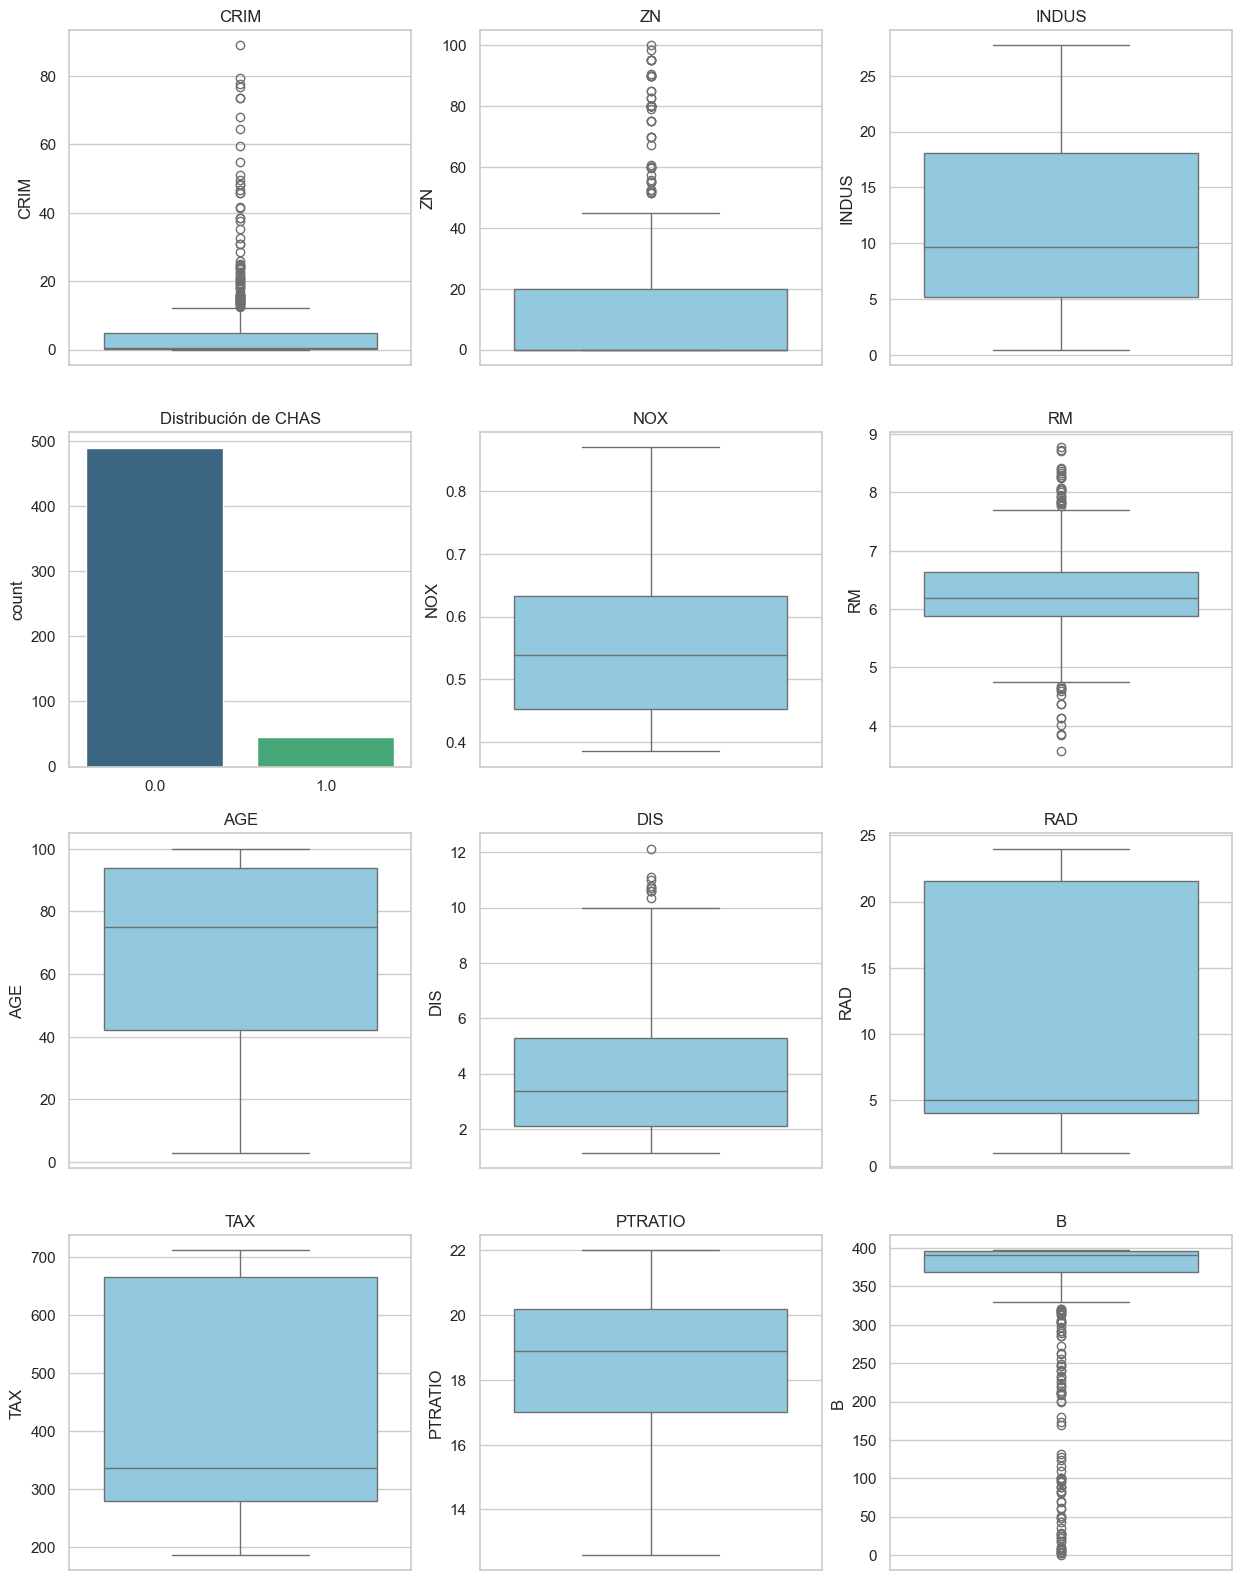

In [120]:
# Configuración de estilo de seaborn
sns.set_theme(style="whitegrid")

# Número de columnas para los boxplots (ajusta este número según sea necesario)
num_columns = len(df_precios_casas.columns)

# Calcular el número de filas necesarias
num_rows = (num_columns + 1) // 3  # Añadimos 1 para incluir el gráfico de barras

# Crear una figura y una serie de subplots
plt.figure(figsize=(15, 5 * num_rows))  # Ajusta el tamaño de la figura según el número de filas

# Crear gráficos para cada columna del DataFrame de características
for i, column in enumerate(df_precios_casas.columns):
    plt.subplot(num_rows, 3, i + 1)  # Define la posición del subplot
    if column == 'CHAS':
        # Crear un gráfico de barras para la columna CHAS
        sns.countplot(data=df_precios_casas, x='CHAS', palette="viridis", hue=None)
        plt.title('Distribución de CHAS')
    else:
        # Crear un boxplot para otras columnas
        sns.boxplot(data=df_precios_casas[column], color="skyblue")
        plt.title(column)
    plt.xlabel('')  # Eliminar la etiqueta del eje x para una mejor visualización

# Ajustar el espaciado entre subplots
plt.tight_layout()

# Mostrar los gráficos
plt.show()

In [30]:
X = df_precios_casas.drop(columns=['MEDV'])  #Asumiendo que 'MEDV' es la variable objetivo
y = df_precios_casas['MEDV']

#division en entrenamiento y prueba
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X, y, test_size=0.3, random_state=42)

#este se utiliza mas adelante para los gradientes
X_train, X_val, y_train, y_val = train_test_split(X_train_original, y_train_original, test_size=0.125, random_state=42)

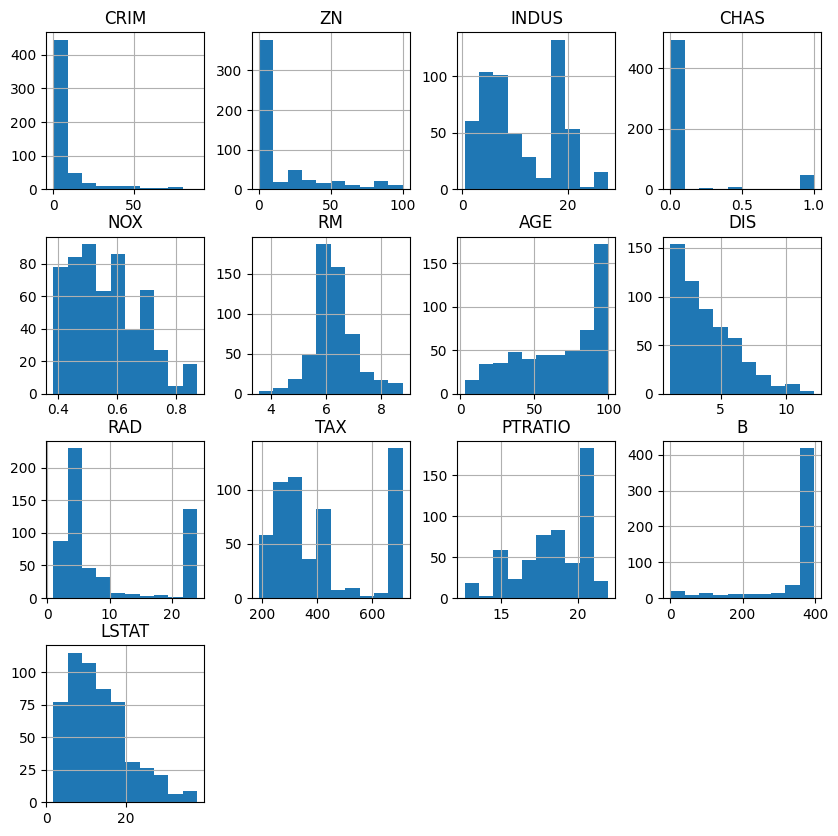

In [ ]:
#histograma de data_imputed
X_train_imputed.hist(figsize=(10, 10))
plt.show()


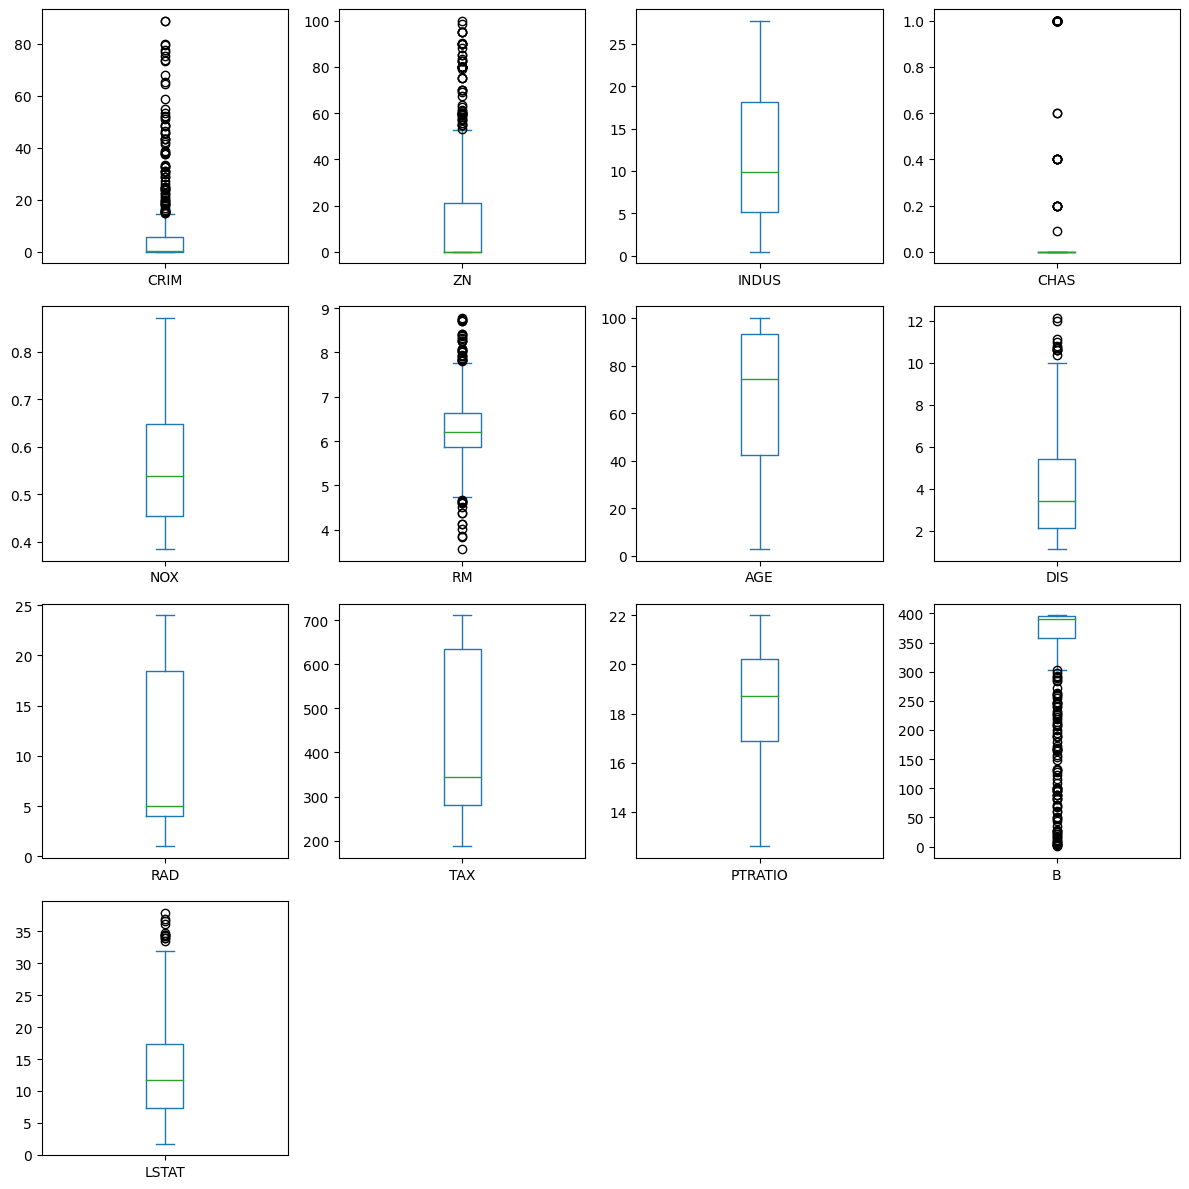

In [ ]:
# Generar los diagramas de caja
X_train_imputed.plot(kind='box', subplots=True, layout=(4, 4), figsize=(12, 12), sharex=False, sharey=False)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [ ]:
#grafico de dispersion de data_imputed
#sns.pairplot(data_imputed)

#este me quedó horrible

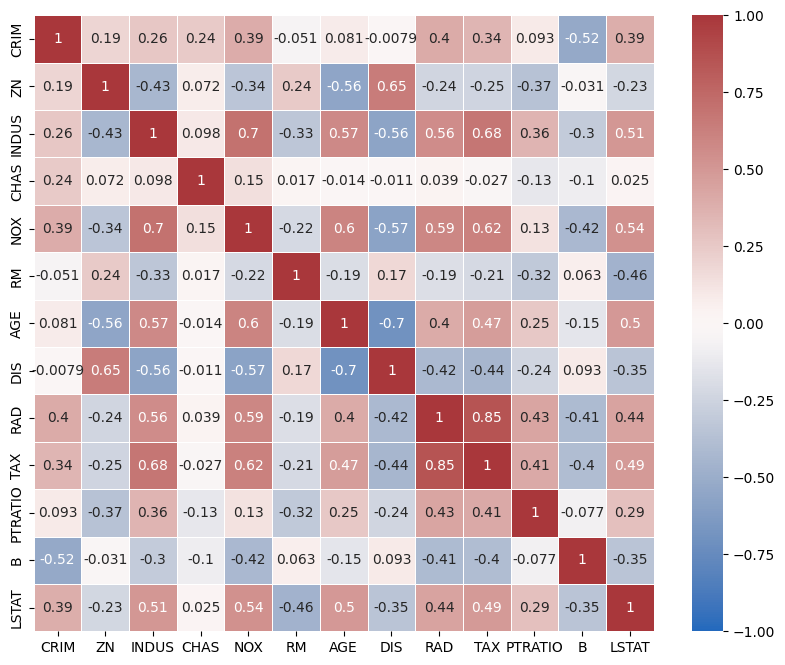

In [ ]:
# Matriz de correlación
correlation_matrix = X_train_imputed.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='vlag', linewidths=0.5, vmin=-1, vmax=1)
plt.show()


#division de datos en conjunto de entrenamiento y pruebas

In [ ]:
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression

# Probar con diferentes valores de n_neighbors
for n in [5, 7, 9, 10, 11, 13, 14, 15, 17]:

    # Entrenamiento y evaluación de un modelo simple
    model = LinearRegression()
    model.fit(X_train_imputed, y_train_imputed)
    scores = cross_val_score(model, X_train_imputed, y_train_imputed, cv=5, scoring='neg_mean_squared_error')

    print(f'n_neighbors={n}, Cross-Validation MSE: {-scores.mean()}')


n_neighbors=5, Cross-Validation MSE: 36.95384054641081
n_neighbors=7, Cross-Validation MSE: 36.95384054641081
n_neighbors=9, Cross-Validation MSE: 36.95384054641081
n_neighbors=10, Cross-Validation MSE: 36.95384054641081
n_neighbors=11, Cross-Validation MSE: 36.95384054641081
n_neighbors=13, Cross-Validation MSE: 36.95384054641081
n_neighbors=14, Cross-Validation MSE: 36.95384054641081
n_neighbors=15, Cross-Validation MSE: 36.95384054641081
n_neighbors=17, Cross-Validation MSE: 36.95384054641081


In [ ]:
#otro modelo
scores = cross_val_score(model, X_train_imputed, y_train_imputed, cv=5, scoring='neg_mean_squared_error')

In [ ]:
#otro modelo
pendiente = model.coef_
intercepto = model.intercept_
print("Pendiente:", pendiente)
print("Intercepto:", intercepto)
#despues lo sigo pero ahi trate de construir y entrenar el modelo.


Pendiente: [ 2.19140462e-03  5.21062083e-02  3.15344864e-02  5.16535592e+00
 -1.45385500e+00  3.71692469e+00 -5.59084196e-02 -1.02789481e+00
  2.01458066e-01 -1.33907399e-02 -8.37314232e-01  8.92660639e-03
 -4.06037081e-01]
Intercepto: 27.56771945874041


In [ ]:
from sklearn.linear_model import SGDRegressor
#modelo del gradiente descendente estocastico
# Crear el modelo
model1 = SGDRegressor()
# Entrenar el modelo
model1.fit(X_train_imputed, y_train_imputed)
# Realizar predicciones
y_pred = model1.predict(X_test_original)

# Calcular el error cuadrático medio (MSE

#print(y_pred)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_original, y_pred)
print("Mean Squared Error:", mse)
r2 = model1.score(X_test_original, y_test_original)
print("R^2:", r2)


In [ ]:
#ver las columnas donde hay valores Nan en x_test_original
nan_columns = X_test_original.columns[X_test_original.isna().any()].tolist()
print(nan_columns)

['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']


In [ ]:
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.07151,0.0,4.49,0.0,0.449,6.121,56.8,3.7476,3.0,247.0,18.5,395.15,8.44,22.2
1,0.08265,0.0,13.92,0.0,0.437,6.127,18.4,5.5027,4.0,289.0,16.0,396.90,8.58,23.9
2,0.12816,12.5,6.07,0.0,0.409,5.885,33.0,6.4980,4.0,345.0,18.9,396.90,8.79,20.9
3,0.08873,21.0,5.64,0.0,0.439,5.963,45.7,6.8147,4.0,243.0,16.8,395.56,13.45,19.7
4,0.11432,0.0,8.56,0.0,0.520,6.781,71.3,2.8561,5.0,384.0,20.9,395.58,7.67,26.5


gradiente descendente

ValueError: x and y must be the same size

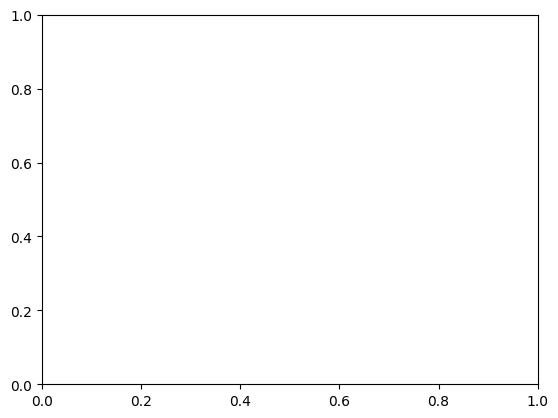

In [ ]:
def gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_val = pxm
        y_test = px1
        W = mx1
    """
    n = X_train.shape[0]
    m = X_train.shape[1]

    o = X_val.shape[0]

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))


    # Inicializar pesos aleatorios
    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época

    for _ in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W)
        error_train = y_train - prediction_train
        #print(error_train)
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de prueba
        prediction_test = np.matmul(X_val, W)
        error_test = y_val - prediction_test
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    # Graficar errores de entrenamiento y prueba
    # Definir una figura
    plt.figure(figsize=(12, 6))
    # Plotear errores de entrenamiento
    plt.plot(train_errors, label='Error de entrenamiento')
    # Plotear errores de prueba
    plt.plot(test_errors, label='Error de validación')
    # Poner labels en los ejes
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    # Activar la leyenda
    plt.legend()
    # Poner titulo
    plt.title('Error de entrenamiento y validación vs iteraciones (GD)')
    # Terminar y mostrar gráfico
    plt.show()

    return W

X_train_imputed.shape, X_val.shape, X_test_original.shape, y_train_imputed.shape, y_val.shape, y_test_original.shape
#X_train.values.reshape(11,7)
fig, ax = plt.subplots()
ax.scatter(X_train_imputed.values, y_train_imputed, s=10)
ax.scatter(X_val.values, y_val, s=10, color='red')

ax.set_xlabel('Income')
ax.set_ylabel('Happiness')
ax.legend(['Train', 'Validation'])
plt.show()

In [ ]:
X_train_imputed.shape, X_val.shape, X_test_original.shape, y_train_imputed.shape, y_val.shape, y_test_original.shape
gradient_descent(X_train_imputed, y_train_imputed, X_test_original, y_test_original, epochs=200, lr=0.00001)

ValueError: Data must be 1-dimensional, got ndarray of shape (556, 556) instead

In [ ]:

print("Shape of X_train_imputed:", X_train_imputed.shape)
print("Shape of y_train_imputed:", y_train_imputed.shape)


Shape of X_train_imputed: (556, 13)
Shape of y_train_imputed: (556,)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

De todo el tp me fui guiando con esto que mi tiró el amigardo

# Análisis de Datos y Modelado

## 1. Análisis Descriptivo de los Datos

- **Análisis de datos faltantes**:
  - Identifica si hay valores faltantes en tu dataset y decide cómo manejarlos (por ejemplo, imputación, eliminación).

- **Visualización de datos**:
  - Genera histogramas, diagramas de dispersión (scatterplots), y diagramas de caja (boxplots) para comprender mejor la distribución de cada variable.

- **Codificación de variables categóricas**:
  - Si alguna variable es categórica, conviértela en variables numéricas (usualmente se utiliza One-Hot Encoding).

- **Matriz de correlación**:
  - Calcula la correlación entre variables para ver cómo se relacionan entre sí.

- **Estandarización o escalado de datos**:
  - Aplica técnicas de escalado como la normalización o estandarización si es necesario.

## 2. División de los Datos en Entrenamiento y Prueba

- Realiza una división de los datos en conjuntos de entrenamiento y prueba (usualmente 70% entrenamiento y 30% prueba).

## 3. Implementación de Modelos de Regresión

- **Regresión Lineal Múltiple**:
  - Usa `LinearRegression` de scikit-learn.

- **Gradiente Descendiente**:
  - Implementa regresión utilizando métodos de gradiente descendiente y analiza si hay cambios significativos.

- **Métodos de Regularización**:
  - Aplica Lasso, Ridge, y Elastic Net para ver cómo afectan los resultados.

## 4. Evaluación de Modelos

- Calcula métricas como R² Score, MSE, RMSE, MAE, MAPE tanto en el conjunto de entrenamiento como en el de prueba.

- Compara el rendimiento entre los distintos modelos.

## 5. Optimización de Hiperparámetros

- Varía los hiperparámetros en los métodos de gradiente descendiente y regularización, observa cómo cambian los resultados.

## 6. Comparación de Modelos

- Realiza una comparación final de todos los modelos para determinar cuál es el mejor basado en las métricas adecuadas.


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Generar un conjunto de datos de ejemplo
X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=42)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los datos (el escalado es recomendable pero no siempre necesario para este caso)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Crear y entrenar el modelo usando gradiente descendente por lotes (usado internamente por LinearRegression)
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Realizar predicciones
y_pred = regressor.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
print(f"Error cuadrático medio: {mse:.4f}")
